In [1]:
import scispacy
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import zipfile
import os
import xmltodict
import json
import zlib
import resource
import sys
import regex as re
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import nltk.data
import time
from multiprocessing import Pool
from nltk.tokenize import word_tokenize

from datasketch import MinHash, MinHashLSH
#nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

### Increase Recursion Depth

In [2]:
print (resource.getrlimit(resource.RLIMIT_STACK))
print (sys.getrecursionlimit())

max_rec = 0x100000

resource.setrlimit(resource.RLIMIT_STACK, [0x100 * max_rec, resource.RLIM_INFINITY])
sys.setrecursionlimit(max_rec)

(8388608, -1)
3000


##### Filetr by aticle type LT and AR

In [3]:
article_df = pd.read_hdf('data/nature/preprocessed/article_df.hdf')

In [3]:
article_df

,ArticleID,DOI,Issue,Volume,PageEnd,PageStart,PubYear,SortDate,Title,Type,Journal
0,048485a0,10.1038/048485a0,1247.0,48.0,508.0,485.0,1893,1893-09-21,The British Association,ed,Nature
1,048508a0,10.1038/048508a0,1247.0,48.0,509.0,508.0,1893,1893-09-21,The Thieving of Assyrian Antiquities\r\n,lt,Nature
2,048509a0,10.1038/048509a0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Bishop's Ring\r\n,lt,Nature
3,048509b0,10.1038/048509b0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Spring and Autumn of 1893\r\n,lt,Nature
4,048509c0,10.1038/048509c0,1247.0,48.0,512.0,509.0,1893,1893-09-21,Notes,misc,Nature
...,...,...,...,...,...,...,...,...,...,...,...
395498,149145b0,10.1038/149145b0,3770.0,149.0,146.0,145.0,1942,1942-01-31,NATIVE SUBSISTENCE ON THE AMERICAN CENTRAL PLAINS,nw,Nature
395499,149146a0,10.1038/149146a0,3770.0,149.0,146.0,146.0,1942,1942-01-31,EARTHQUAKE ORIGINS IN THE NEW ZEALAND REGION,nw,Nature
395500,149146b0,10.1038/149146b0,3770.0,149.0,146.0,146.0,1942,1942-01-31,FORTHCOMING EVENTS,misc,Nature
395501,149146c0,10.1038/149146c0,3770.0,149.0,146.0,146.0,1942,1942-01-31,APPOINTMENTS VACANT,misc,Nature


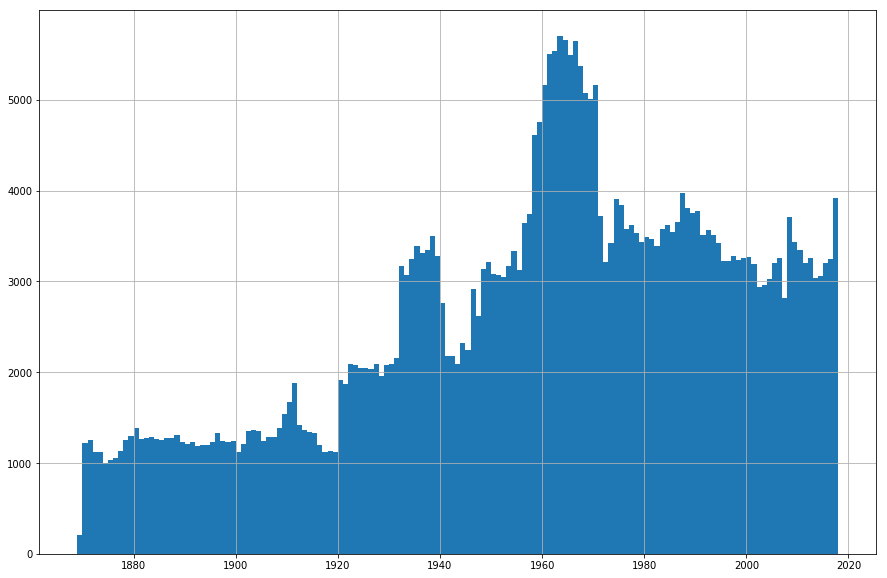

In [4]:
article_df['PubYear'].hist(bins = (article_df['PubYear'].max() - article_df['PubYear'].min()), figsize = (15, 10))

In [5]:
x = list(article_df[['ArticleID','PubYear']].groupby('PubYear').count()['ArticleID'])

In [57]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(w))

In [58]:
for coef,freq in zip(w,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(395503+0j) * exp(2 pi i t * 0.0)
(-47741.08173227605+108296.56565066085j) * exp(2 pi i t * 0.006666666666666667)
(-2916.647505104697-4446.201373113057j) * exp(2 pi i t * 0.013333333333333334)
(10539.743735805234+19397.577300762736j) * exp(2 pi i t * 0.02)
(-25020.935120043745+20768.783330945193j) * exp(2 pi i t * 0.02666666666666667)
(12143.577118135774-11115.604172927051j) * exp(2 pi i t * 0.03333333333333333)
(-7739.549818821184+29193.817441610612j) * exp(2 pi i t * 0.04)
(-11897.168711957263+2992.0775355719984j) * exp(2 pi i t * 0.04666666666666667)
(-2124.4129891429643+1883.9264314710495j) * exp(2 pi i t * 0.05333333333333334)
(-2058.8926500048374+8760.953164608516j) * exp(2 pi i t * 0.060000000000000005)
(-12443.556051734498-732.4449024497588j) * exp(2 pi i t * 0.06666666666666667)
(7775.474178371135+8722.553310698155j) * exp(2 pi i t * 0.07333333333333333)
(-10919.90605381349-3971.8651346329198j) * exp(2 pi i t * 0.08)
(-2641.354099406623+6462.622597416276j) * exp(2 pi i t * 0.0

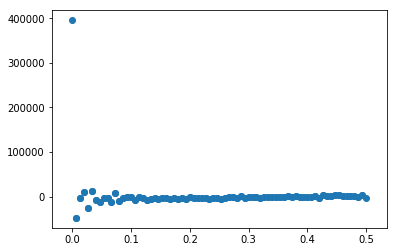

In [63]:
plt.scatter(abs(freqs), w)

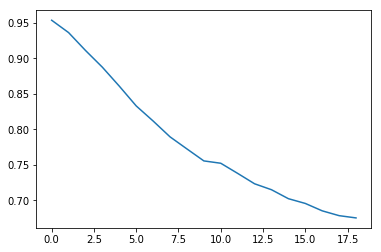

In [125]:
def autocorr(x, max_lag, steps):
    
    results = []
    
    for i in range(1, max_lag, steps):
        
        x_hat = np.append(np.zeros(i), x[:len(x)-i])
        results.append(np.corrcoef(x, x_hat)[1][0])
        
    return results

plt.plot(autocorr(x, 20, 1))

In [135]:
article_df.loc[0]

ArticleID                   048485a0
DOI                 10.1038/048485a0
Issue                           1247
Volume                            48
PageEnd                          508
PageStart                        485
PubYear                         1893
SortDate                  1893-09-21
Title        The British Association
Type                              ed
Journal                       Nature
Name: 0, dtype: object

In [145]:
with open('data/nature/preprocessed/abstract_df.pickle', 'rb') as f:
        abstract_df = pickle.load(f)

In [149]:
abstract_df

,ArticleID,Abstract
0,048485a0,THE Nottingham meeting of the British Associat...
1,048508a0,I HAD hoped that the British Museum slander ca...
2,048509a0,BISHOP'S RING still continues very conspicuous...
3,048509b0,As the peculiarities of this season are receiv...
4,048509c0,"MR. W. SAVILLE-KENT, at present engaged as Com..."
...,...,...
395498,149145b0,"IN a recent paper, W. R. Wedel dealt with man'..."
395499,149146a0,"R. C. HAYES, acting director of the Dominion O..."
395500,149146b0,(\nMeeting marked with an asterisk is open to ...
395501,149146c0,APPLICATIONS are invited for the following app...


In [159]:
directory = 'data/nature/raw xml/'
zfile = zipfile.ZipFile(os.path.join(directory, os.listdir(directory)[0]))

for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        line_list = ifile.readlines()

In [171]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [169]:
line_list[np.argmax(['4402' in str(line) for line in line_list])]

b'<iss>4402</iss>\r\n'

In [161]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [172]:
line_list

[b'<?xml version="1.0"?>\r\n',
 b'<!DOCTYPE headerx PUBLIC "-//NPG//DTD headerx//EN" "headerx.dtd">\r\n',
 b'<headerx>\r\n',
 b'<ArticleIdList>\r\n',
 b'<ArticleId>173508a0</ArticleId></ArticleIdList>\r\n',
 b'<pubfm>\r\n',
 b'<jtl>Nature</jtl>\r\n',
 b'<vol>173</vol>\r\n',
 b'<iss>4402</iss>\r\n',
 b'<idt>19540313</idt>\r\n',
 b'<categ id="categtxt"/>\r\n',
 b'<categtxt>Reports and other Publications</categtxt>\r\n',
 b'<pp><spn>508</spn><epn>508</epn></pp>\r\n',
 b'<issn>0028-0836</issn>\r\n',
 b'<cpg><cpy>1954</cpy><cpn>Nature Publishing Group</cpn></cpg>\r\n',
 b'<doi>10.1038/173508a0</doi>\r\n',
 b'</pubfm>\r\n',
 b'<fm>\r\n',
 b'<atl>Reports and other Publications</atl>\r\n',
 b'</fm>\r\n',
 b'<bdy>(not included in the monthly Books Supplement)\r\n',
 b'Great Britain and Ireland\r\n',
 b'Air Ministry : Meteorological Office. Averages of Temperature for Great Britain and Northern Ireland 1921-50. Pp. ii &plus; 36. (London : H.M. Stationery Office, 1953.) 2s. net. [121\r\n',
 b'Min

In [173]:
len(os.listdir(directory))

7867

In [190]:
os.listdir(directory)

['nature_v173_n4402_xml.zip',
 'nature_v18_n449_xml.zip',
 'nature_v260_n5554_xml.zip',
 'nature_v232_n5308_xml.zip',
 'nature_v485_n7400test-jo_xml.zip',
 'nature_v201_n4914_xml.zip',
 'nature_v57_n1476_xml.zip',
 'nature_v72_n1854_xml.zip',
 'nature_v57_n1468_xml.zip',
 'nature_v22_n554_xml.zip',
 'nature_v127_n3205_xml.zip',
 'nature_v78_n2034_xml.zip',
 'nature_v87_n2175_xml.zip',
 'nature_v12_n300_xml.zip',
 'nature_v110_n2772_xml.zip',
 'nature_v176_n4484_xml.zip',
 'nature_v43_n1121_xml.zip',
 'nature_v238_n5358_xml.zip',
 'nature_v258_n5531_xml.zip',
 'nature_v10_n237_xml.zip',
 'nature_v67_n1748_xml.zip',
 'nature_v158_n4018_xml.zip',
 'nature_v20_n501_xml.zip',
 'nature_v211_n5050_xml.zip',
 'nature_v369_n6478_xml.zip',
 'nature_v40_n1028_xml.zip',
 'nature_v373_n6512_xml.zip',
 'nature_v156_n3965_xml.zip',
 'nature_v88_n2202_xml.zip',
 'nature_v383_n6601_xml.zip',
 'nature_v104_n2611_xml.zip',
 'nature_v463_n7278_xml.zip',
 'nature_v39_n992_xml.zip',
 'nature_v109_n2738_xml.

In [20]:
def get_reference_mapping(filename, content):
    
    """
    Given XML filename and XML file, extract rid mappings and attribute data
    """
    
    mappings  = {}
    extracted = {}
    references = {}
    parsed    = xmltodict.parse(content.decode('UTF-8'))
    soup      = BeautifulSoup(content)

    if '@id' in parsed['article']:
        extracted['id']       = str(parsed['article']['@id'])
    if '@language' in parsed['article']:
        extracted['language'] = str(parsed['article']['@language'])
    if '@publish' in parsed['article']:
        extracted['publish']  = str(parsed['article']['@publish'])
    if '@relation' in parsed['article']:
        extracted['relation'] = str(parsed['article']['@relation'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('jtl' in parsed['article']['pubfm']):
                extracted['jtl']   = str(parsed['article']['pubfm']['jtl'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['vol']   = str(parsed['article']['pubfm']['vol'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('issue' in parsed['article']['pubfm']):
                extracted['issue'] = str(parsed['article']['pubfm']['issue'])

    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['doi']   = str(parsed['article']['pubfm']['doi'])
    
    if ('article' in parsed):
        if ('fm' in parsed['article']):
            if ('atl' in parsed['article']['fm']):
                extracted['title']   = str(parsed['article']['fm']['atl'])
     
    
    del parsed
    
    for bib in soup.find_all("bib"):
        
        try:
            reference_attr = {}
            
            reference_attr['title']   = str(bib.atl.contents[0])
            reference_attr['snm']     = str([i.contents[0] for i in bib.find_all('snm')])
            reference_attr['fnm']     = str([i.contents[0] for i in bib.find_all('fnm')])
            reference_attr['journal'] = str(bib.jtl.contents[0])
            reference_attr['year']    = str(bib.find_all('cd')[0].contents[0])

            references.update({bib.attrs['id']: reference_attr})
        
        except Exception as e:
            
            if DEBUG == True:
            
                print('='*50)
                print('Something is wrong with BeatifulSoup Tags: %s' % str(bib))
                for i in ['snm', 'fnm', 'jtl', 'year', 'atl']:
                    if len(bib.find_all(i)) == 0:
                        print('%s attribute is missing.' %i)
            
            else: pass
            
    
    references = {'metadata': extracted, 'references': references}
    
    try:
        with open('data/intermediate/references/%s' % (filename + '.json'), 'w') as f:
            f.write(json.dumps(references))
        return True
    
    except TypeError as e:
        #print('Some contents of the file %s is not serializable' % filename)
        raise e
        
        
def get_reference_text(filename, content):
    
    """
    Given XML filename and XML file, extract referencing text and reference metadata
    TODO: Compile all regex to make it faster
    
    Returns  {str(unique_paper_indentifier), list(preceeding_text)}
    """
    
    content   = content.decode('UTF-8')
    bibid     = re.findall(r'<bibr\srid=\"(.*?)\"\s*\/>', content)
    #bibtext   = re.findall(r"\s.*?<bibr\s", content)
    
    bibtext_intermediate = [s for s in sent_detector.tokenize(content)\
                               if re.search(r'<bibr\srid', s)]

    bibtext_intermediate = [s.split('</p>') for s in bibtext_intermediate]
    bibtext_intermediate = [item for sublist in bibtext_intermediate for item in sublist]

    bibtext_intermediate = [s for s in bibtext_intermediate if re.search(r'<bibr\srid', s)]
    text_counter         = [len(re.findall(r'<bibr\srid', s)) for s in bibtext_intermediate]

    bibtext = []

    for i, s in enumerate(bibtext_intermediate):
        while text_counter[i] != 0:
            bibtext.append(s)
            text_counter[i] -= 1
        
    
    assert(len(bibid) == len(bibtext)), "The bibid's and preceeding text don't match: " +\
                                        "for article %s\n" % filename +\
                                        "bibid: %s\n" %bibid +\
                                        "bibtext: %s\n" %bibtext
    
    with open('data/intermediate/tex_ref_mappings/%s' % (filename + '.json'), 'w') as f:
        f.write(json.dumps([{i[1]:i[0].split(' ')} for i in zip(bibid, bibtext)]))
    
    return 


In [22]:
def get_zips():
    
    """
    Function to extract relevant files from the filebase
    """
    
    citations = {}
    directory = 'data/nature/raw xml/'
    zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
    
    errored   = []
    #zfile     = zipfile.ZipFile(os.path.join(directory, zip_list[0]))
    
    for zfile in tqdm(zip_list):
        
        zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

        for finfo in zfile.infolist():

            if 'nature' in finfo.filename:

                try:
                    ifile = zfile.open(finfo)
                    content = ifile.read()
                    tex_ref_map = get_reference_text(finfo.filename, content)
                    ref_id_ref_map = get_reference_mapping(finfo.filename, content)

                    citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
                                                'ref_id_ref_map': ref_id_ref_map}
                except Exception as e:

                    print('Filename: %s, Zip:%s, Content:%s' % (finfo.filename,
                                                                zfile,
                                                                content))
                    errored.append({'Filename':finfo.filename,
                                    'Zip':zfile ,
                                    'Content': content})
                    #return content
                    #raise Exception
            
    return citations, errored
        
#papers, errored = get_zips()

In [23]:
%time

def get_zips_parallel_mapper(directory):
    
    """
    Function to extract relevant files from the filebase
    """
    
    try:
        
        zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
        errored   = []
        finfos    = []
        contents  = []

        for zfile in tqdm(zip_list):

            zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

            for finfo in zfile.infolist():

                if 'nature' in finfo.filename:
                    
                    ifile = zfile.open(finfo)
                    content = ifile.read()

                    finfos.append(finfo)
                    contents.append(zlib.compress(content))

        return finfos, contents
    
    except Exception as e:
        
        print('Could not read file from zip %s, file %s' % (zfile, finfo.name))
        
def get_zips_parallel_reducer(arg):
    
    try:
        finfo, content = arg[0], zlib.decompress(arg[1])
        del arg

        #citations = {}
        #tex_ref_map = get_reference_text(finfo.filename, content)
        #ref_id_ref_map = get_reference_mapping(finfo.filename, content)
        #citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
        #                            'ref_id_ref_map': ref_id_ref_map}
        
        get_reference_text(finfo.filename, content)
        get_reference_mapping(finfo.filename, content)
        
        return True
    
    except Exception as e:
        
        #print('Could not extract references from %s' % finfo)
        return str(Exception)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [27]:
##TEST on one
DEBUG = False
directory     = 'data/nature/raw xml/'
finfos, contents = get_zips_parallel_mapper(directory)
get_zips_parallel_reducer((finfos[2], contents[2]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


True

In [29]:
%time
finfos, contents = get_zips_parallel_mapper(directory)
p = Pool(6)
success = p.map(get_zips_parallel_reducer, zip(finfos, contents))
error_rate = sum([1 if i == True else 0 for i in success])/len(success)
print ('%f of all processed files Succeeded' % error_rate)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



0.999939 of all processed files failed


In [25]:
sum([1 if i == True else 0 for i in success])

4320

In [22]:
with open('data/intermediate/paper_citations.pkl', 'wb') as f:
    pkl.dump(papers, f)

### Step 2: Get reference_text -> reference 1:1 mapping

In [5]:
def build_ref_index(tex_ref_mappings, reference):

    inverse_tex_ref = {}
    
    for tex_refs in tex_ref_mappings:
        
        text, refs = list(tex_refs.items())[0]
        
        for ref in refs: 
            if ref in inverse_tex_ref:
                inverse_tex_ref[ref].append(text)
            else:
                inverse_tex_ref[ref] = [text]
    
    return inverse_tex_ref
    
def read_files():
    
    directory = 'data/intermediate/'
    tex_ref_mappings = []
    references       = []
    
    tex_ref_files = os.listdir(os.path.join(directory, 'tex_ref_mappings'))
    references_files = os.listdir(os.path.join(directory, 'references'))
    
    if len(tex_ref_files) != len(references_files):
        print('Not all text files have a references counterpart.\n'
              'Continuing with the files that do have a mapping')
    
    #file = tex_ref_files[1]
    
    for file in tqdm(tex_ref_files):
        #print(file)
        #print(tex_ref_mappings)
        
        with open(os.path.join(directory, 'tex_ref_mappings', file), 'r', encoding = 'UTF-8') as f0:

            try:
                with open(os.path.join(directory, 'references', file), 'r',  encoding = 'UTF-8') as f1:

                    tex_ref_mappings.append(json.loads(str(f0.read()),  encoding = 'UTF-8'))
                    references.append(json.loads(str(f1.read()),  encoding = 'UTF-8'))

            except IOError as e:
                print('References file %f not found.' % file)
    
    return tex_ref_mappings, references


In [6]:
tex_ref_mappings, references = read_files()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [49]:
len(tex_ref_mappings)/len(reference)

1.0

In [51]:
inverse_tex_ref

{'b1': ['</descrip></suppobj>\r\n</suppinfo>\r\n<doi>10.1038/nature03697</doi></pubfm>\r\n<fm>\r\n<atl>Multiple volcanic episodes of flood basalts caused by thermochemical mantle plumes</atl>\r\n<aug><cau><fnm>Shu-Chuan</fnm><snm>Lin</snm><inits>SC</inits><orf rid="a1" refchar="asterisk"/><corf rid="c1"/></cau><au><fnm>Peter E.</fnm><snm>van Keken</snm><inits>PE</inits><orf rid="a1" refchar="asterisk"/></au>\r\n<aff><oid id="a1"/>Department of Geological Sciences, University of Michigan, <cty>Ann Arbor</cty>, Michigan 48109, <cny>USA</cny></aff>\r\n<caff><coid id="c1"/>Correspondence and requests for materials should be addressed to S. C. L. (<email>skylin@umich.edu</email>).</caff>\r\n</aug>\r\n<hst><re year="2005" month="1" day="17"/><acc year="2005" month="4" day="27"/></hst>\r\n</fm>\r\n<bdy>\r\n<fp><p>The hypothesis that a single mushroom-like mantle plume head can generate a large igneous province within a few million years has been widely accepted<bibr rid="b1"/>.'],
 'b10': ['B

In [151]:
references[1]

{'metadata': {'doi': '10.1038/nature03697',
  'id': 'nature03697',
  'jtl': 'Nature',
  'language': 'eng',
  'publish': 'issue',
  'relation': 'no',
  'title': 'Multiple volcanic episodes of flood basalts caused by thermochemical mantle plumes',
  'vol': '436'},
 'references': {'b1': {'fnm': "['I. H.', 'R. W.']",
   'journal': 'Earth Planet. Sci. Lett.',
   'snm': "['Campbell', 'Griffiths']",
   'title': 'Implications of mantle plume structure for the evolution of flood basalts',
   'year': '1990'},
  'b10': {'fnm': "['J. M.', 'R. A.']",
   'journal': 'J. Geophys. Res.',
   'snm': '["O\'Connor", \'Duncan\']',
   'title': 'Evolution of the Walvis Ridge-Rio Grande Rise hot spot system: Implications for African and South American Plate motions over plumes',
   'year': '1990'},
  'b11': {'fnm': "['K.']",
   'journal': 'Earth Planet. Sci. Lett.',
   'snm': "['Stewart']",
   'title': '3-D, ',
   'year': '1996'},
  'b12': {'fnm': "['D.', 'J.']",
   'journal': 'Science',
   'snm': "['Bercovici

In [185]:
def get_forest(references, perms, threshold):

    start_time = time.time()
    minhash = []
    titles = []
    
    for paper in tqdm(references[:100]):
        for text in paper['references'].values():
            
            snm    = ' '.join(text['snm'].replace('\'', '').replace('[', '').replace(']','').split(','))
            fnm    = ' '.join(text['fnm'].replace('\'', '').replace('[', '').replace(']','').split(','))
            year   = ' '.join(text['year'].replace('\'', '').replace('[', '').replace(']','').split(','))
            tokens = nltk.word_tokenize(text['title'] + ' ' + snm + ' ' + fnm + ' ' + year)
            m      = MinHash(num_perm=perms)
            
            for s in tokens:
                m.update(s.encode('utf8'))
            
            minhash.append(m)
            titles.append(text['title'] + ' ' + snm + ' ' + fnm + ' ' + year)
        
    lsh = MinHashLSH(threshold = threshold, num_perm=perms)
    
    with lsh.insertion_session() as session:
        for i,m in enumerate(minhash):
            session.insert(i,m)

    print('It took %s seconds to build map.' %(time.time()-start_time))
    
    return lsh, minhash, titles

In [181]:
def test_lsh(queries):
    
    recall = []
    sensitivity = []

    for i, query in enumerate(tqdm(queries)):
        m = MinHash(num_perm=128)
        for s in nltk.word_tokenize(query):
            #print(s)
            m.update(s.encode('utf8'))

        if i in lsh.query(m):
            recall.append(1)
            sensitivity.append(1/len(lsh.query(m)))
        else:
            recall.append(0)
            sensitivity.append(0)
    
    return recall, sensitivity

In [168]:
lsh, minhash, titles = get_forest(references, 128, 0.1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



It took 9.920639276504517 seconds to build map.


In [182]:
recall, sensitivity = test_lsh(titles)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [183]:
sum(recall)/len(recall)

1.0

In [184]:
sum(sensitivity)/len(sensitivity)

0.007466314150903604

In [189]:
np.mean(sensitivity)

0.007466314150903594

In [ ]:
roc_sens = {}
roc_recal = {}

for threshold in np.arange(0.0, 1, 0.1):
    print (threshold)
    lsh, minhash, titles = get_forest(references, 128, threshold)
    recall, sensitivity = test_lsh(titles)
    
    roc_recal[threshold] =  np.mean(recall)
    roc_sens[threshold]  = np.mean(sensitivity)

0.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



It took 10.703874826431274 seconds to build map.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



0.1



It took 10.019591808319092 seconds to build map.


In [117]:
len(titles)

2807

In [27]:
list(references[3]['references'].values())

[{'fnm': "['Y.']",
  'journal': 'Curr. Biol.',
  'snm': "['Song']",
  'title': 'Adaptive introgression of anticoagulant rodent poison resistance by hybridization between Old World mice',
  'year': '2011'},
 {'fnm': "['J. R. G.']",
  'journal': 'Annu. Rev. Ecol. Syst.',
  'snm': "['Turner']",
  'title': 'Adaptation and evolution in ',
  'year': '1981'},
 {'fnm': "['C.']",
  'journal': 'BMC Evol. Biol.',
  'snm': "['Kemkemer']",
  'title': 'Gene synteny comparisons between different vertebrates provide new insights into breakage and fusion events during mammalian karyotype evolution',
  'year': '2009'},
 {'fnm': "['E. G.']",
  'journal': 'Genetics',
  'snm': "['Pringle']",
  'title': 'Synteny and chromosome evolution in the Lepidoptera: evidence from mapping in ',
  'year': '2007'},
 {'fnm': "['O.']",
  'journal': 'Trends Ecol. Evol.',
  'snm': "['Seehausen']",
  'title': 'Hybridization and adaptive radiation',
  'year': '2004'},
 {'fnm': "['R. I.', 'M.']",
  'journal': 'Philos. Trans. R

In [28]:
references[3]

{'metadata': {'doi': '10.1038/nature11041',
  'id': 'nature11041',
  'jtl': 'Nature',
  'language': 'eng',
  'relation': 'no',
  'title': 'Butterfly genome reveals promiscuous exchange of mimicry adaptations among species',
  'vol': '487'},
 'references': {'b1': {'fnm': "['O.']",
   'journal': 'Trends Ecol. Evol.',
   'snm': "['Seehausen']",
   'title': 'Hybridization and adaptive radiation',
   'year': '2004'},
  'b10': {'fnm': '[]',
   'journal': 'Insect Biochem. Mol. Biol.',
   'snm': '[]',
   'title': 'Silkworm Genome Consortium. The genome of a lepidopteran model insect, the silkworm ',
   'year': '2008'},
  'b11': {'fnm': "['E. G.']",
   'journal': 'Genetics',
   'snm': "['Pringle']",
   'title': 'Synteny and chromosome evolution in the Lepidoptera: evidence from mapping in ',
   'year': '2007'},
  'b13': {'fnm': "['Q.', 'Q.', 'Y.', 'C.', 'Y.']",
   'journal': 'J. Genet. Genomics',
   'snm': "['Deng', 'Zeng', 'Qian', 'Li', 'Yang']",
   'title': 'Research on the karyotype and evol

In [30]:
tex_ref_mappings[3]

[{'</descrip></suppobj>\r\n    </suppinfo>\r\n<subject code="npg_subject_212"/><subject code="npg_subject_181"/><subject code="npg_subject_208"/><subject code="npg_subject_601"/>\r\n<subject id="2467" path="/631/181/759/2467" type="npg.subject" version="1.0"/>\n<subject id="748" path="/631/208/212/748" type="npg.subject" version="1.0"/>\n<subject id="18" path="/631/601/18" type="npg.subject" version="1.0"/>\n<doi>10.1038/nature11041</doi>\r\n<licence model="by-nc-sa" version="3.0"><weblink url="http://creativecommons.org/licenses/by-nc-sa/3.0/">Creative Commons Attribution-Non-Commercial-Share Alike licence</weblink><licence-text>This article is distributed under the terms of the Creative Commons Attribution-Non-Commercial-Share Alike licence (<weblink url="http://creativecommons.org/licenses/by-nc-sa/3.0/">http://creativecommons.org/licenses/by-nc-sa/3.0/</weblink>).</licence-text></licence></pubfm>\r\n<fm>\r\n<atl>Butterfly genome reveals promiscuous exchange of mimicry adaptations a

In [66]:
set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'datasets'])
set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])
set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
            'estimating', 'the', 'similarity', 'between', 'documents'])

m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)

In [67]:
m1